In [1]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 1.6MB 7.3MB/s 
     |████████████████████████████████| 174kB 32.6MB/s 
     |████████████████████████████████| 51kB 9.7MB/s 
     |████████████████████████████████| 1.2MB 28.1MB/s 
     |████████████████████████████████| 686kB 27.9MB/s 
     |████████████████████████████████| 38.2MB 78kB/s 
     |████████████████████████████████| 358kB 48.4MB/s 
     |████████████████████████████████| 102kB 15.6MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=62c46fb0b2b4ffde2a22d43f21c814c4f1f8405a8510543c453cbb564d95aeed
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-cp37-none-any.whl size=22258 sha256=22072c2869f214270959fd24f16321bd3959ab902e718bd4895cdddd44aa83bc
  Stored in directory: /root/.cache/pip/wheels/2e/15/f5/aa2a056d223903b52cf4870134

In [2]:
import pandas as pd
from string import punctuation 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
 
import matplotlib.pyplot as plt
import os

import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter("ignore")


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data

split our training data to train and validation data 


In [4]:
df = pd.read_csv('/content/drive/My Drive/training.1600000.processed.noemoticon.csv',
                 encoding='ISO-8859-1',
                 names=['target','id','date','nq','username','txt'])

In [5]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.txt.values
y = sampleDf.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [6]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [7]:
x_train

array(['I FOUND OUT THAT THEY PAY THE WHITE CHICK MORE THAN ME  WHY?? I DONT KNOW!!! WHAT SHOULD I DO???',
       "@nickheppleston It's an enlightening experience, isn't it? ",
       'Twitter me your tour thoughts... What cities? What songs? What shall I wear? ',
       ..., 'swallow listerine ',
       'i need to clean and do laundry and should grocery shop and take water sample to pool people.  but its &gt;90 and sticky ',
       '~a sunny weekend in Hyderabad, pretty warm indoors, on my way to explore the city with mom and dad, anticipating a mail from a loved one '],
      dtype=object)

In [8]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [9]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [10]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [11]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([encode_names(n) for n in x_train])

In [12]:
tweets.shape.as_list()

[64000, None]

In [13]:
tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

I [146]
F [143]
##O [11403]
##UN [69849]
##D [11490]
O [152]
##UT [65729]
T [157]
##HA [58132]
##T [11090]
THE [17443]
##Y [14703]
PA [32349]
##Y [14703]
THE [17443]
W [160]
##HI [108880]
##TE [29833]
CH [39774]
##IC [30889]
##K [11733]
MO [102059]
##RE [66014]
T [157]
##HA [58132]
##N [11537]
ME [47430]
W [160]
##H [12396]
##Y [14703]
? [136]
? [136]
I [146]
DO [99843]
##NT [77261]
K [148]
##NO [67292]
##W [13034]
! [106]
! [106]
! [106]
W [160]
##HA [58132]
##T [11090]
SH [38702]
##O [11403]
##UL [100673]
##D [11490]
I [146]
DO [99843]
? [136]
? [136]
? [136]


bert's inputs

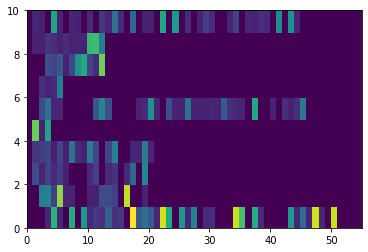

In [14]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(64000, 160), dtype=int32)


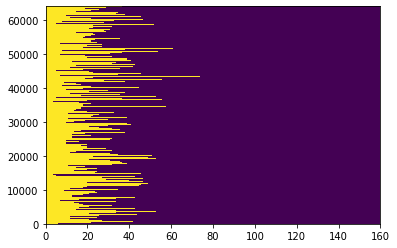

In [15]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
print(input_mask)
plt.pcolormesh(input_mask)

tf.Tensor(
[[0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 ...
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]], shape=(64000, 160), dtype=int32)


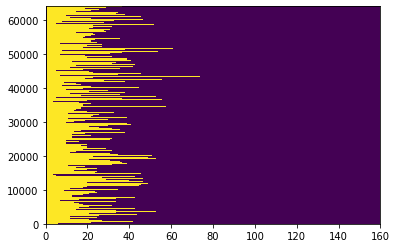

In [16]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()
print(input_type_ids)
plt.pcolormesh(input_type_ids)

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type(segment_id)

It will make our work easier both now and in the future if we remake everything into funcitons.



In [17]:
lens = [len(i) for i in input_word_ids]

In [18]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 160


In [19]:
max_seq_length=int(1.5*max_seq_length)
print(max_seq_length)

240


HHHHHHHHH range all the lines above in one functon called bert_encode

In [20]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  length = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

#load from our function the inputs as a dictionary

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [21]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

In [22]:

max_seq_length = max_seq_length  

#building our inputs layers

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")

#building our outputs layers(we use just pooled_output in our case)

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids ])   

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

output = tf.keras.layers.Dense(2, activation='softmax', name='output')(output)

#buiding our model

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
        },
        outputs=output)

some hyperparametre of our optimazer (adamW=AdamWeightDecay)

In [23]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [24]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [26]:
our_model_bert_for_twitter = model.fit(X_train,                                       
                                    dummy_y_train,
                                    epochs=epochs,
                                    batch_size=batch_size,
                                    validation_data=(X_test, dummy_y_test),
                                    verbose=1)

Epoch 1/3
4000/4000 [==============================] - 3689s 918ms/step - loss: 0.4833 - accuracy: 0.7660 - val_loss: 0.4119 - val_accuracy: 0.8138
Epoch 2/3
4000/4000 [==============================] - 3629s 907ms/step - loss: 0.3564 - accuracy: 0.8470 - val_loss: 0.4293 - val_accuracy: 0.8253
Epoch 3/3
4000/4000 [==============================] - 3630s 908ms/step - loss: 0.2600 - accuracy: 0.8970 - val_loss: 0.4744 - val_accuracy: 0.8292


save our model

In [31]:
print('g')

g


In [42]:
dataset_name = 'twitter'
saved_model_path = '/content/drive/MyDrive/{}_bert'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/twitter_bert/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/twitter_bert/assets
